# Load Financial database
## Load stock data from CSMAR

In [30]:
from csmarapi.CsmarService import CsmarService
csmar = CsmarService()

In [31]:
# Load DB credentials from .env and log in to CSMAR
# Prerequisite: pip install python-dotenv and create a .env file with DB_USER and DB_PASS
# Security note: avoid hardcoding secrets in notebooks; use environment variables instead.
import os
from dotenv import load_dotenv

# Load variables from .env into the current environment
load_dotenv()

# Read CSMAR credentials (make sure .env defines DB_USER and DB_PASS)
# You can replace these with your actual credentials
user = os.getenv("DB_USER")
pwd  = os.getenv("DB_PASS")

# Authenticate with the CSMAR service using the credentials
csmar.login(user, pwd)

Sun 31 Aug 2025 16:11:56 CsmarService.py INFO User login succeed


In [32]:
# Download stock data for Pingan Bank
data = csmar.query_df( ['Stkcd','Trddt','Opnprc','Hiprc', 'Loprc', 'Clsprc'], 
                      "Stkcd=000001", 'TRD_Dalyr','2005-01-01','2009-12-31')
print(data)

       Stkcd       Trddt  Opnprc  Hiprc  Loprc  Clsprc
0     000001  2005-01-04    6.59   6.59   6.46    6.52
1     000001  2005-01-05    6.52   6.55   6.35    6.46
2     000001  2005-01-06    6.50   6.59   6.45    6.52
3     000001  2005-01-07    6.58   6.60   6.46    6.51
4     000001  2005-01-10    6.51   6.59   6.37    6.59
...      ...         ...     ...    ...    ...     ...
1132  000001  2009-12-23   22.76  23.06  22.28   22.55
1133  000001  2009-12-24   22.65  23.31  22.46   23.28
1134  000001  2009-12-29   23.40  23.81  23.00   23.59
1135  000001  2009-12-30   23.59  24.53  23.42   24.39
1136  000001  2009-12-31   24.38  24.69  24.09   24.37

[1137 rows x 6 columns]


In [ ]:
# Export data
data.to_csv('pingan_bank_stock_data.csv', index=False)

<Axes: title={'center': 'Pingan Bank Stock Price (2005-2009)'}, xlabel='Trddt'>

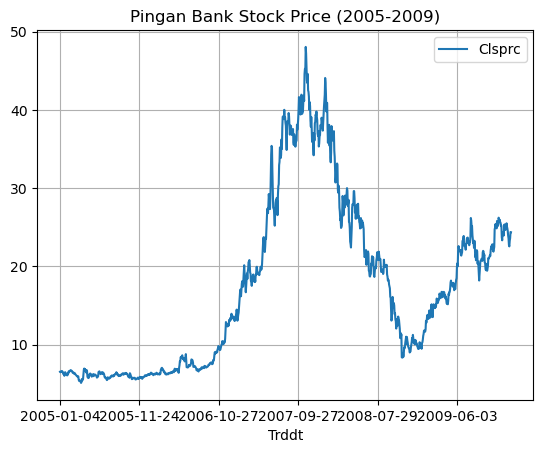

In [33]:
data.plot(x='Trddt', y='Clsprc', title='Pingan Bank Stock Price (2005-2009)', grid=True)

## Load Microsoft stock data from WRDS

In [24]:
# Download monthly MSFT data (2000-2015) from WRDS CRSP and plot close price
# Prerequisite: pip install wrds; you will be prompted for your WRDS credentials
# Tip: set environment variable WRDS_USERNAME to skip the username prompt
import wrds
import pandas as pd
import matplotlib.pyplot as plt

load_dotenv()

# Optional: read WRDS username from environment (WRDS_USER)
wrds_user = os.getenv("WRDS_USER")

# Connect to WRDS (prompts for credentials if not cached)
conn = wrds.Connection(wrds_username=wrds_user)

Loading library list...
Done
Done


In [25]:
# Use CRSP monthly stock file (msf) and map MSFT ticker to PERMNO via stocknames
sql = """
WITH msft_perm AS (
  SELECT DISTINCT permno
  FROM crsp.stocknames
  WHERE ticker = 'MSFT'
)
SELECT
  msf.date,
  msf.permno,
  ABS(msf.prc) AS prc,   -- CRSP stores prc possibly negative for bid/ask direction
  msf.cfacpr
FROM crsp.msf AS msf
JOIN msft_perm ap ON msf.permno = ap.permno
WHERE msf.date BETWEEN '2000-01-01' AND '2015-12-31'
ORDER BY msf.date;
"""

# Fetch data (parse date)
df = conn.raw_sql(sql, date_cols=["date"]) 
conn.close()  # close connection when done

In [27]:
df.head()

,date,permno,prc,cfacpr
0,2000-01-31,10107,97.875,2.0
1,2000-02-29,10107,89.375,2.0
2,2000-03-31,10107,106.25,2.0
3,2000-04-28,10107,69.75,2.0
4,2000-05-31,10107,62.5625,2.0


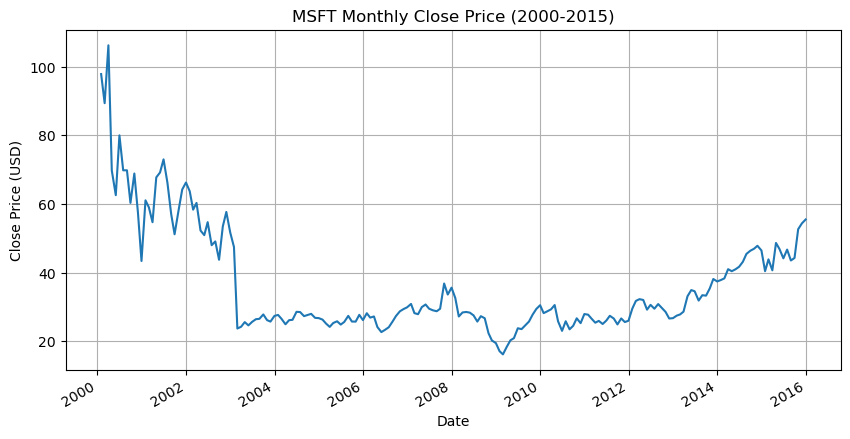

In [28]:
# Plot close (monthly)
df = df.sort_values("date")
ax = df.set_index("date")["prc"].plot(
    figsize=(10, 5),
    title="MSFT Monthly Close Price (2000-2015)",
    grid=True,
)
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
plt.show()

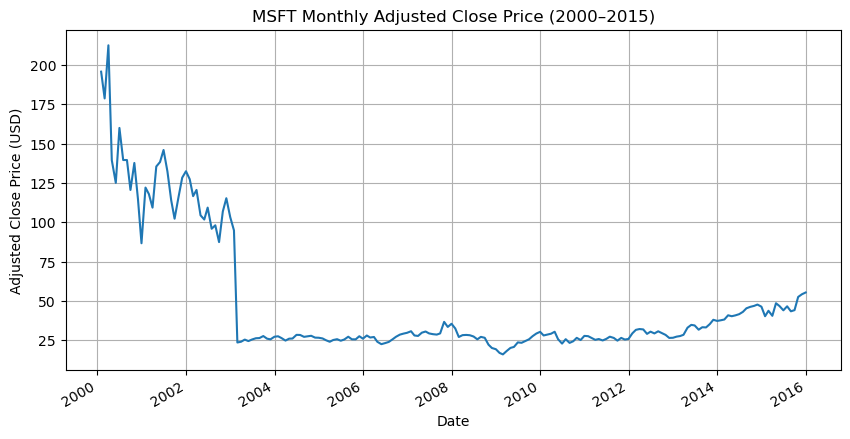

In [29]:
# Optionally compute split-adjusted price (commented out)
df["adj_prc"] = df["prc"] * df["cfacpr"]

# Plot adjusted close (monthly)
df = df.sort_values("date")
ax = df.set_index("date")["adj_prc"].plot(
    figsize=(10, 5),
    title="MSFT Monthly Adjusted Close Price (2000–2015)",
    grid=True,
)
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Close Price (USD)")
plt.show()